In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import SphericalVoronoi
from src import *

In [2]:
def annealing(func, X0, neighbor_func, temperature_schedule, max_iter, tol=1e-8):
    current_solution = X0
    current_objective = func(current_solution)
    
    best_solution = current_solution
    best_objective = current_objective
    
    for t in range(max_iter):
        temperature = temperature_schedule(t)

        neighbor = neighbor_func(current_solution)
        neighbor_objective = func(neighbor)
        
        delta = neighbor_objective - current_objective
        acceptance_probability = np.exp(-delta / temperature) if delta > 0 else 1.0
        
        if np.random.rand() < acceptance_probability:
            current_solution = neighbor
            current_objective = neighbor_objective
        
        if current_objective < best_objective:
            best_solution = current_solution
            best_objective = current_objective
            if current_objective < tol:
                break

        print(f"temp: {temperature:.4f}, \tcur_obj: {current_objective}, \tbest_obj: {best_objective}")
    
    return best_solution, best_objective

In [3]:
def change_random_row(x):
    index = np.random.randint(len(x))
    r = 2 + np.random.randn() / 2
    delta = np.random.randn(len(x[index]))
    delta = delta / np.linalg.norm(delta) * r

    new_x0 = x.copy()
    new_x0[index] = new_x0[index] + delta

    return renorm(new_x0)

In [4]:
def neighbor(x, gd_params=(300, 1e-6, 0.01, True)):
    new_x0 = change_random_row(x)
    return accelerated_gradient(func, grad, new_x0, *gd_params)

In [5]:
def neighbor_kdt(x, params=(10, 30, 500, 1e-6, 0.01, True)):
    new_x0 = change_random_row(x)
    return accelerated_gradient_kdt(func, new_x0, *params)

In [6]:
def temperature(iteration, max_iter, t_init, t_final):
    return t_init - (t_init - t_final) * iteration / max_iter

In [7]:
def k_opt_step(func, x, k, params, tol=1e-6, silent=False):
    # also returns if the search was successful
    
    current_obj = func(x)

    for i in range(len(x)**k):
        candidate = x.copy()
        for j in range(k):
            candidate = change_random_row(candidate)
        # candidate = accelerated_gradient(func, grad, candidate, *gd_params)
        candidate = accelerated_gradient_kdt(func, candidate, *params)
        if func(candidate) < current_obj - tol:
            return candidate, True

        if not silent and i > 0:
            if i % 100 == 0:
                print(f"i = {i} \tout of {len(x)**k}")

    return x, False

In [8]:
def multiopt(func, x0, params, tol=1e-6):
    x = x0.copy()
    cur_obj = func(x)

    k = 1
    
    while cur_obj > tol:
        if func(x) < tol:
            break
        print(f"k: {k}, \tcur_obj: {func(x):.8f}")
        
        x, succ = k_opt_step(func, x, k, params)
        if not succ:
            k += 1
        else:
            k = 1

    return x

In [9]:
n = 11
N = 400
X0 = renorm(np.random.randn(N,n))

sol = multiopt(func, X0, (10, 30, 500, 1e-6, 0.01, True))
func(sol), sol

In [10]:
max_iter = 100
t_max = 0.1
t_min = 0

sol, obj = annealing(func, X0, neighbor, lambda t: temperature(t, max_iter, t_max, t_min), max_iter)
func(sol), sol

In [11]:
n = 2
N = 6
X0 = renorm(np.random.randn(N,n))

In [12]:
sv = SphericalVoronoi(X0, 1, np.zeros_like(X0[0]))

(-1.1, 1.1)

<Figure size 700x700 with 0 Axes>

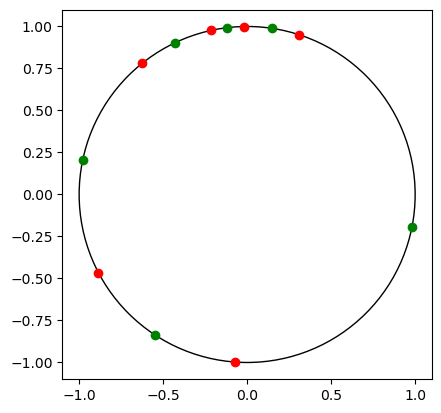

In [13]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
plt.scatter(X0[:,0], X0[:,1], c='r')
plt.scatter(sv.vertices[:,0], sv.vertices[:,1], c='g')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [24]:
def sample_potential_minimums(X, num_points, params=(100, 1e-4, 0.03, True)):
    points = np.random.randn(num_points, X.shape[1])
    return accelerated_gradient(lambda p: np.sum(potentials_in_points(X, p)), lambda p: grad_potentials(X, p), points, *params)

In [19]:
def smart_k_opt(func, x, k, num_tries, t_max, params, tol=1e-6, silent=False):
    # also returns if the search was successful
    
    current_obj = func(x)
    sv = SphericalVoronoi(x, 1, np.zeros_like(x[0]))
    sv_vertices = sv.vertices
    
    # potentials_x = potentials(x)
    # potentials_x = np.maximum(0, potentials(x))
    # potentials_x = potentials_x / np.max(potentials_x)

    tree = KDTree(x)

    closest_dists, _ = tree.query(x, k=1)
    potentials_x = np.maximum(0, 1 - closest_dists)
    potentials_x = potentials_x / np.max(potentials_x)
    
    potentials_vertices = np.maximum(0, potentials_in_points(x, sv_vertices))
    potentials_vertices = potentials_vertices / np.max(potentials_vertices)

    for i in range(num_tries):
        probas_x = np.exp(potentials_x * t_max * (num_tries - i) / num_tries)
        probas_x = probas_x / np.sum(probas_x)
        probas_vertices = np.exp(- potentials_vertices * t_max * (num_tries - i) / num_tries)
        probas_vertices = probas_vertices / np.sum(probas_vertices)
        
        candidate = x.copy()
        index_x = np.random.choice(np.arange(len(x)), k, p=probas_x, replace=False)
        np.random.shuffle(index_x)
        index_vertex = np.random.choice(np.arange(len(sv_vertices)), k, p=probas_vertices, replace=False)
        np.random.shuffle(index_vertex)
        candidate[index_x] = sv_vertices[index_vertex].copy()
        candidate = accelerated_gradient_kdt(func, candidate, *params)
        if func(candidate) < current_obj - tol:
            print(f"success at iteration {i}")
            return candidate, True

        if not silent and i > 0:
            if i % 100 == 0:
                print(f"i = {i} \tout of {num_tries}")

    print(f"no success after {num_tries} iterations")
    return x, False

In [20]:
def smart_multiopt(func, x0, ceiling_iters, t_max, params, tol=1e-6):
    x = x0.copy()
    cur_obj = func(x)

    k = 1
    
    while cur_obj > tol:
        if func(x) < tol:
            break
        print(f"k: {k}, \tcur_obj: {func(x):.8f}")

        
        x, succ = smart_k_opt(func, x, k, np.minimum(ceiling_iters, len(x0)**np.minimum(k, 2)), t_max, params)
        if not succ:
            k += 1
        else:
            k = 1

    return x

In [21]:
n = 5
N = 38
X0 = renorm(np.random.randn(N,n))

In [22]:
%%time
sv = SphericalVoronoi(X0, 1, np.zeros_like(X0[0]))
len(sv.vertices)

CPU times: user 11.2 ms, sys: 1.9 ms, total: 13.1 ms
Wall time: 11 ms


506

In [23]:
%%time
sol = smart_multiopt(func, X0, 500, 3, (10, 20, 500, 1e-6, 0.01, True)) 
func(sol), sol

k: 1, 	cur_obj: 20.91945918
success at iteration 0
k: 1, 	cur_obj: 0.03625459
success at iteration 0
k: 1, 	cur_obj: 0.00127960
success at iteration 11
k: 1, 	cur_obj: 0.00050642
success at iteration 0
k: 1, 	cur_obj: 0.00040966
success at iteration 21
k: 1, 	cur_obj: 0.00006304
success at iteration 4
k: 1, 	cur_obj: 0.00000749
success at iteration 1
k: 1, 	cur_obj: 0.00000136
success at iteration 13
CPU times: user 8.99 s, sys: 2.95 ms, total: 8.99 s
Wall time: 8.99 s


(np.float64(5.374900524657278e-11),
 array([[-3.27397005e-01,  5.20776489e-02, -2.05514768e-01,
         -4.20765750e-01, -8.19035399e-01],
        [ 6.03766929e-01, -5.21178675e-01,  1.62704068e-01,
          5.25709913e-01, -2.46971169e-01],
        [ 7.31990734e-01,  2.34261482e-01, -3.50065375e-01,
         -3.76744915e-01,  3.80563563e-01],
        [ 7.91476166e-01, -2.39976361e-01,  4.59455625e-01,
         -3.21860983e-01,  3.58170506e-02],
        [ 1.24120018e-01,  3.56941759e-01, -4.77966167e-01,
          3.63982229e-01, -7.04451618e-01],
        [ 4.60326142e-02,  1.14970598e-01, -5.85659982e-02,
          9.86085477e-01, -9.41712021e-02],
        [ 7.36295331e-01, -1.63177110e-01, -3.57323388e-01,
         -1.88860442e-01, -5.17584917e-01],
        [ 3.41624990e-01,  5.80508449e-01,  5.41292046e-01,
         -3.31362926e-01,  3.78819006e-01],
        [-1.18243255e-01, -2.09860635e-01,  6.82854497e-01,
         -6.62069437e-01,  1.93263661e-01],
        [-3.38141392e-01,  5

In [29]:
mins = sample_potential_minimums(sol, 10)
mins, potentials_in_points(sol, mins), potentials_in_points(sol, renorm(np.random.randn(10, 5)))

(array([[ 0.27879257,  0.13878979,  0.35574351,  0.57443725, -0.66819196],
        [-0.34573026,  0.1945035 ,  0.60927004,  0.06328803, -0.68368386],
        [-0.31603339, -0.93826551, -0.09164673,  0.09978158, -0.03775236],
        [-0.31603341, -0.9382655 , -0.09164673,  0.09978157, -0.03775243],
        [-0.04199607,  0.75991589, -0.05579608,  0.64619224, -0.00930329],
        [-0.32462903,  0.10409748,  0.82296442, -0.07056516,  0.44892073],
        [-0.1049878 , -0.23263497,  0.67893831, -0.67265204,  0.14642586],
        [ 0.55010275,  0.66958323, -0.16384303, -0.40124731, -0.24738901],
        [ 0.54996345,  0.66972626, -0.16397061, -0.40110108, -0.24746413],
        [ 0.32701065, -0.36684876, -0.51162245, -0.69575472,  0.11248939]]),
 array([0.58727547, 0.70662514, 0.45977432, 0.45977432, 0.85023046,
        0.39264088, 0.99886882, 0.88125026, 0.88125023, 0.81966643]),
 array([1.17712992, 1.18304987, 1.07446924, 0.88831068, 1.16148698,
        0.94431946, 1.04688056, 1.02625744

### spherical Voronoi is too heavy in dimension >=10